In [165]:
from ClassiPyGRB import SWIFT
# Packages needed for this notebook
import os
import numpy as np

In [166]:
import torch
import torch.nn as nn
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [167]:
%matplotlib inline
swift = SWIFT(root_path=r'data', res=64, n_bands=[1,2,3,4,5])
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV', '15-350keV']


In [168]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz'))
grb_names, features = data_loaded['names'], data_loaded['data']
durations = swift.total_durations(grb_names, t=90)

Finding Durations: 100%|███████████████████| 1502/1502 [00:16<00:00, 88.59GRB/s]


In [169]:
print(np.mean(features,axis=1))
print(np.std(features,axis=1))

[0.00032766 0.00032651 0.00032281 ... 0.00032555 0.00032945 0.00032601]
[0.00571496 0.00451738 0.00645361 ... 0.0026599  0.00901    0.00360951]


In [170]:
# to save compute, cutoff using the 95th percentile
old_lightcurve_length = int(features.shape[1]/5)
new_lightcurve_length = 5000
bands = np.array([None]*5)
for i in range(5):
    bands[i] = features[:,i*old_lightcurve_length:i*old_lightcurve_length + new_lightcurve_length]
features = np.hstack(bands)
# furthermore, use total flux to save compute time
features = features[:,4*new_lightcurve_length:]

In [171]:
# Normalize the features here
normalized_features = (features - np.mean(features, axis=1, keepdims=1))/np.std(features,axis=1,keepdims=1)
print(normalized_features.shape)
print(np.mean(normalized_features,axis=1))
print(np.std(normalized_features,axis=1))

(1502, 5000)
[ 1.13686838e-17 -4.54747351e-17  0.00000000e+00 ... -4.54747351e-17
  1.13686838e-17  0.00000000e+00]
[1. 1. 1. ... 1. 1. 1.]


In [172]:
_normalized_features = normalized_features # copy this so rerunning next cell doesn't throw error
_labels = np.zeros(shape=(normalized_features.shape[0],1))

In [173]:
normalized_features = torch.from_numpy(_normalized_features).to(torch.float32)
labels = torch.from_numpy(_labels).to(torch.float32)

# Check for rows with NaN values and remove them from both features and labels
mask = ~torch.isnan(normalized_features).any(dim=1) & ~torch.isnan(labels).any(dim=1)
clean_features = normalized_features[mask]
clean_labels = labels[mask]

# Split the cleaned data into training and testing sets
X_train, X_test, class_train, class_test = train_test_split(clean_features, clean_labels, test_size=0.2, random_state=205)


training_dataset = TensorDataset(X_train, class_train)
test_dataset = TensorDataset(X_test, class_test)

BATCHSIZE = 128
BATCHSIZE_TEST = 256

train_dataloader = DataLoader(training_dataset, batch_size=BATCHSIZE, shuffle=True)
test_dataloader  = DataLoader(test_dataset, batch_size=BATCHSIZE_TEST, shuffle=True)

In [174]:
INPUT_SIZE      = features.shape[1]
LATENT_SIZE     = 5
HIDDEN_SIZE_1     = 500
HIDDEN_SIZE_2     = 50

In [175]:
# Note that this code is largely from https://github.com/LSSTC-DSFP/LSSTC-DSFP-Sessions/tree/main/Sessions/Session14
# First, we will inherit from pytorch Module class; https://pytorch.org/docs/stable/generated/torch.nn.Module.html

class Encoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Encoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # here we are initializing the linear layers. This registeres the layer parameters (W,b) as parameters of the Module
        self.fc1 = nn.Linear(INPUT_SIZE,HIDDEN_SIZE_1)
        self.fc2 = nn.Linear(HIDDEN_SIZE_1,HIDDEN_SIZE_2)
        self.fc3 = nn.Linear(HIDDEN_SIZE_2,LATENT_SIZE)

        # We will initialize weights following a multivariate Gaussian
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.01)

    # this defines a forward pass of the network (="applying" the network to some input data)
    def forward(self, x):
        # print(x.dtype)
        # print(self.fc1.weight.dtype)
        # print(self.fc1.bias.dtype) # for debugging dtype mismatch
        x      = torch.nn.LeakyReLU()(self.fc1(x))
        x      = torch.nn.LeakyReLU()(self.fc2(x))
        z      = self.fc3(x)
        return z

class Decoder(nn.Module):
    def __init__(self, seed=205):
        """
        seed: int, random seed for reproducibility
        """
        super(Decoder, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Using the encoder, how will you initialize two layers?
        self.fc1 = nn.Linear(LATENT_SIZE,HIDDEN_SIZE_2)
        self.fc2 = nn.Linear(HIDDEN_SIZE_2,HIDDEN_SIZE_1)
        self.fc3 = nn.Linear(HIDDEN_SIZE_1,INPUT_SIZE)

        # Using the endoer, how will you initialize the weights and biases?
        nn.init.normal_(self.fc1.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc1.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc2.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc2.bias, mean=0, std=0.01)
        nn.init.normal_(self.fc3.weight, mean=0, std=0.01)
        nn.init.normal_(self.fc3.bias, mean=0, std=0.01)

    def forward(self, z):
        # Using the encoder, how will you define the forward pass?
        # I recommend the same activation function!
        z      = torch.nn.LeakyReLU()(self.fc1(z))
        z      = torch.nn.LeakyReLU()(self.fc2(z))
        x      = self.fc3(z)
        return x

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # here we are creating instances of the Encoder and Decoder class
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        x = self.decoder(z)
        return x

In [176]:
# This creates an instance of the Autoencoder class
AE = Autoencoder()
full_path = "Autoencoder_Noise_Reduced_64res_12345bands_final-500state_dict.pth"
AE.load_state_dict(torch.load(full_path))

<All keys matched successfully>

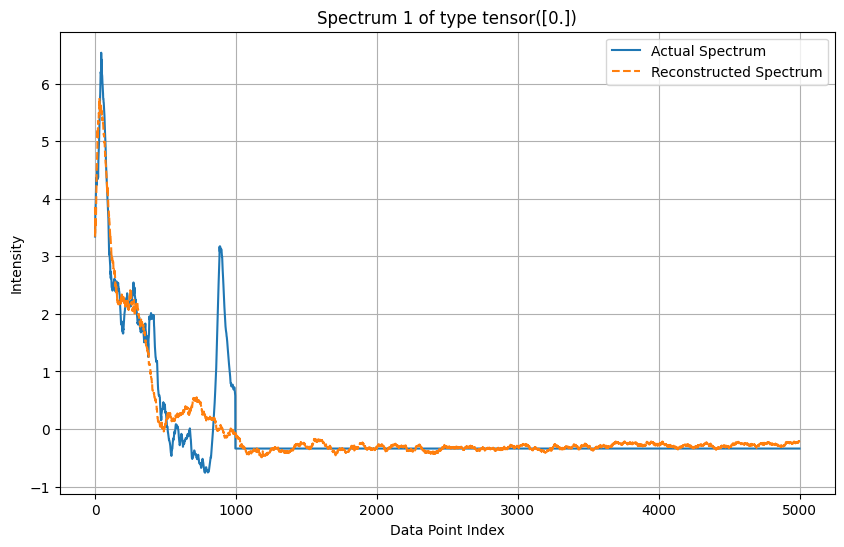

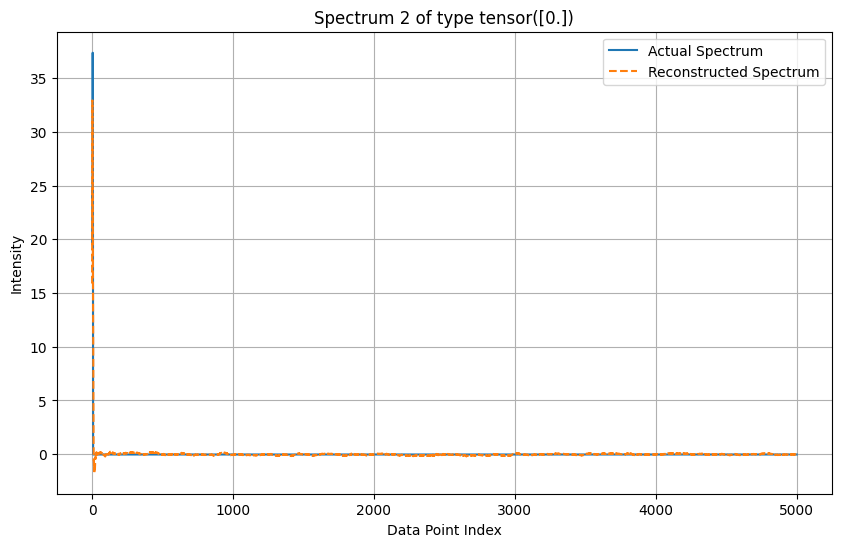

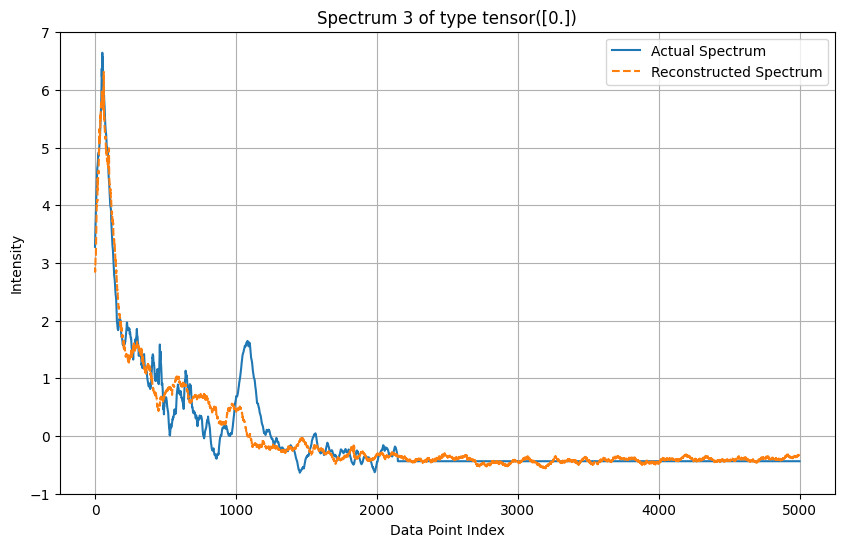

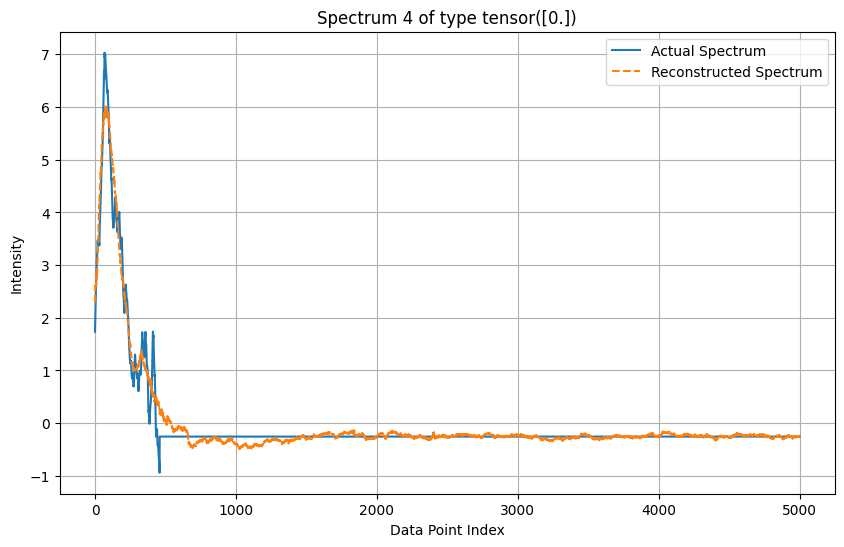

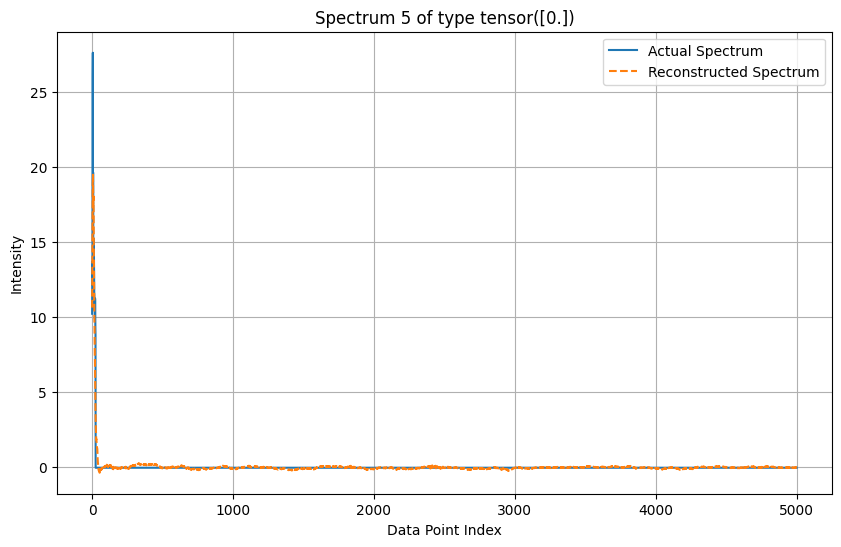

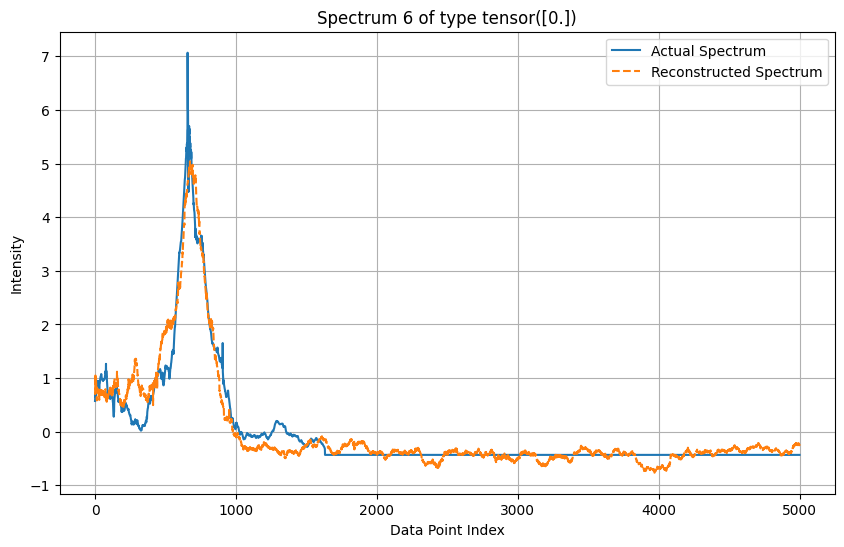

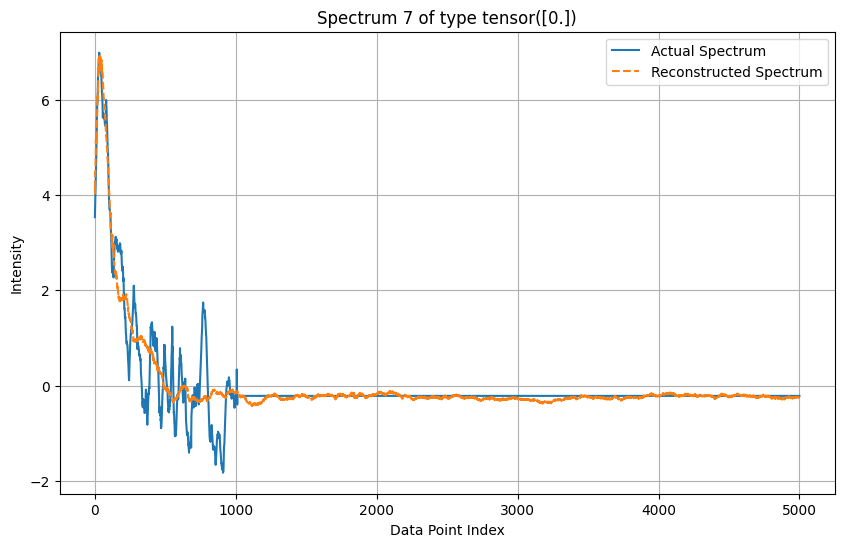

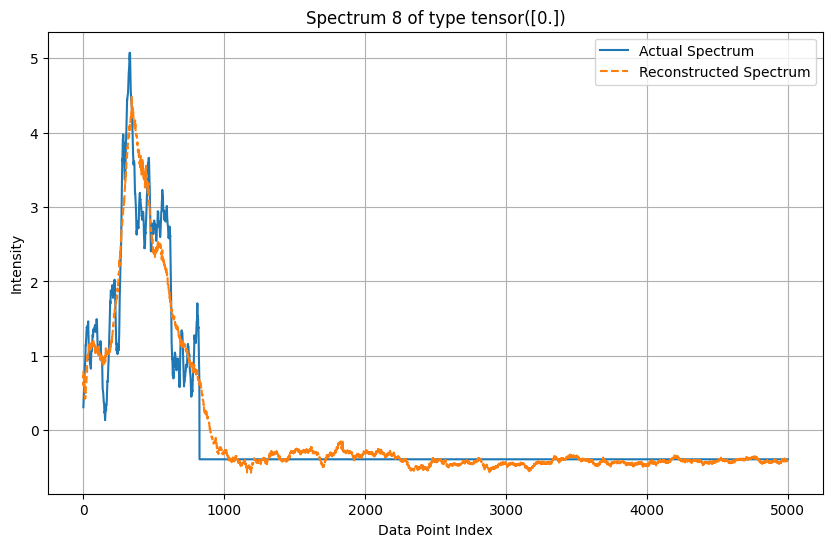

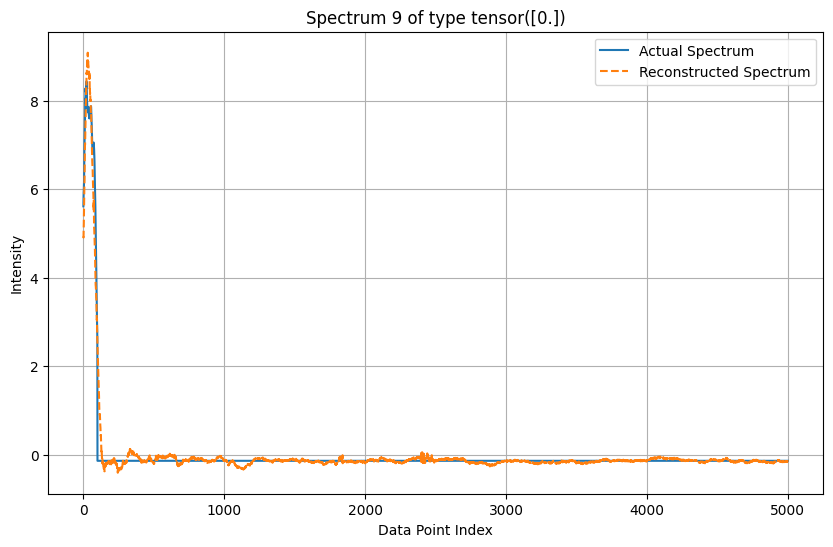

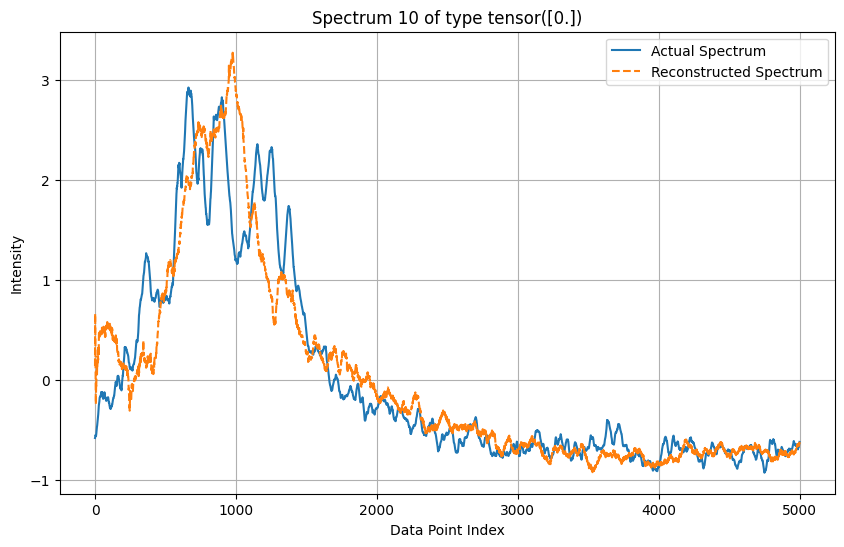

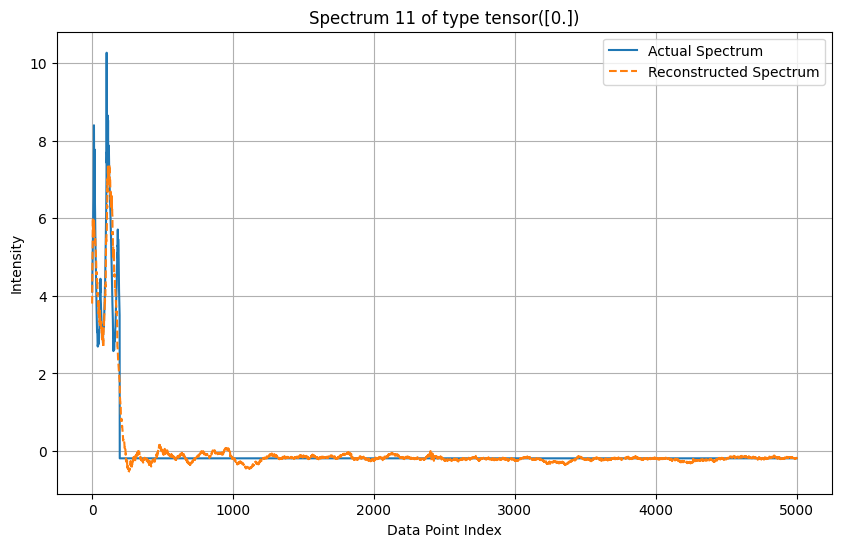

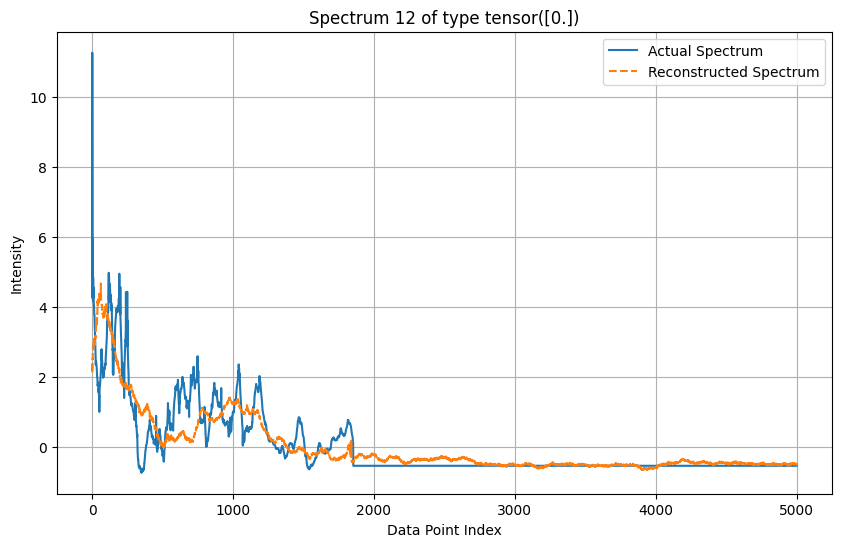

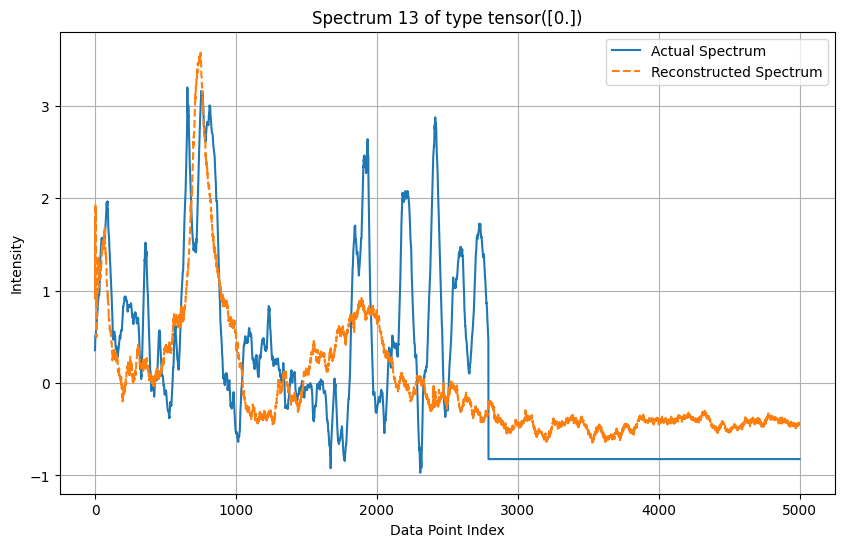

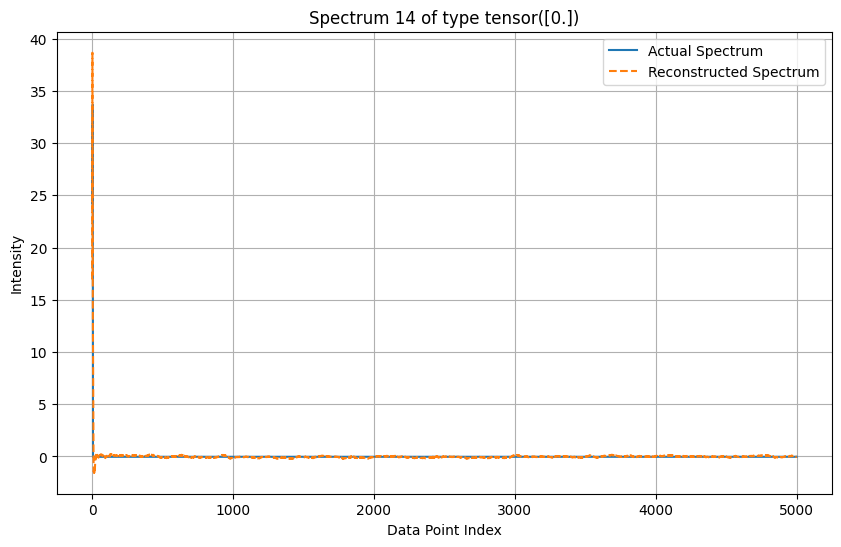

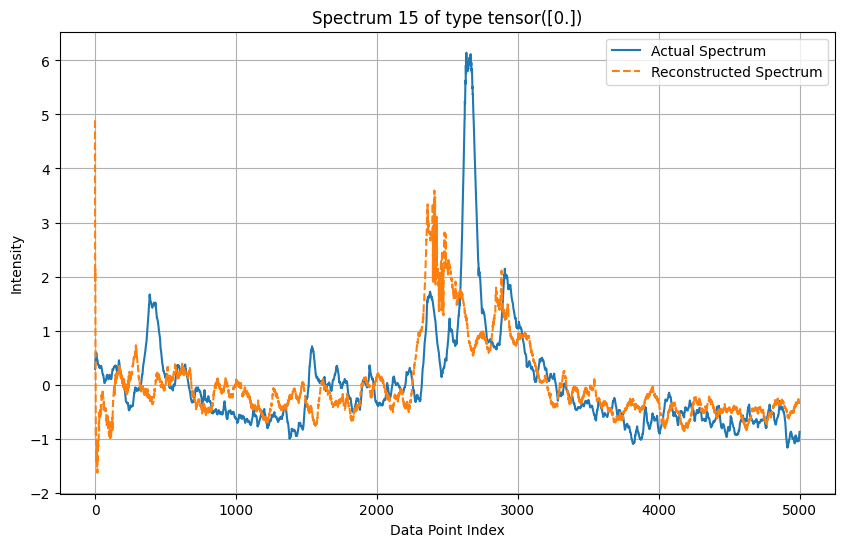

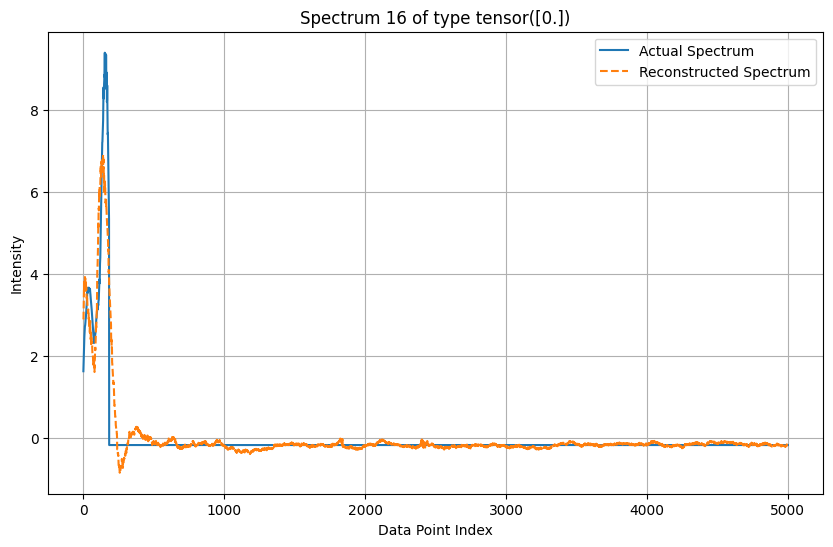

In [177]:
vis_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) # get 16 random spectra

for X_batch, y_batch in vis_loader:
    # Simulated x-axis values for the spectrum
    x = np.linspace(0, features.shape[1], features.shape[1])
    
    with torch.no_grad():
        preds = AE(X_batch).detach()
    
    for i in range(len(X_batch)):
        plt.figure(figsize=(10, 6))
        plt.plot(x, X_batch[i].numpy(), label='Actual Spectrum')  # Converting tensor to numpy array for plotting
        plt.plot(x, preds[i].numpy(), label='Reconstructed Spectrum',linestyle='--')
        plt.title(f'Spectrum {i+1} of type {y_batch[i]}')
        plt.xlabel('Data Point Index')
        plt.ylabel('Intensity')
        plt.legend()
        plt.grid(True)
    break # just need one batch of 16

In [262]:
preds2 = []
for x in features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[-0.1351,  2.2085,  1.6363,  0.5836,  1.8434],
        [-0.1337,  1.6338,  1.1163, -0.1153,  1.9470],
        [-0.8242,  2.7810,  1.9562,  0.6618,  1.3271],
        ...,
        [ 0.5167,  0.3031,  0.2568, -0.1665,  1.4559],
        [-1.8682,  3.9536,  2.6481,  1.3196,  1.0507],
        [ 0.2304,  0.6785,  0.3308, -0.5539,  2.0241]])

In [263]:
preds2 = []
for x in normalized_features:
    with torch.no_grad():
        # Convert x from a NumPy array to a PyTorch tensor
        x_tensor = torch.tensor(x, dtype=torch.float32)
        
        # Add a batch dimension to x
        x_tensor = x_tensor.unsqueeze(0)
        preds2.append(AE.encoder(x_tensor).detach())

preds2 = torch.cat(preds2)
preds2

tensor([[ -0.3097,  97.2791,  83.3813,   8.4342,  75.3038],
        [  3.0460,  89.4977,  74.1889, -24.8285, 102.5252],
        [-25.2402, 105.1252,  82.6750,   7.9849,  47.9873],
        ...,
        [ 72.7246,  26.7973,  31.5264, -33.1412, 151.9476],
        [-47.8680, 108.1515,  79.2888,  24.9825,  25.0405],
        [ 32.1876,  48.9404,  26.9472, -51.2658, 152.0765]])

In [264]:
mask = ~torch.isnan(preds2).any(dim=1)
preds2 = preds2[mask]

In [265]:
encoded2 = preds2

In [266]:
kmeans2 = KMeans(n_clusters=2, random_state=205).fit(preds2)
kmeans2

KMeans(n_clusters=2, random_state=205)

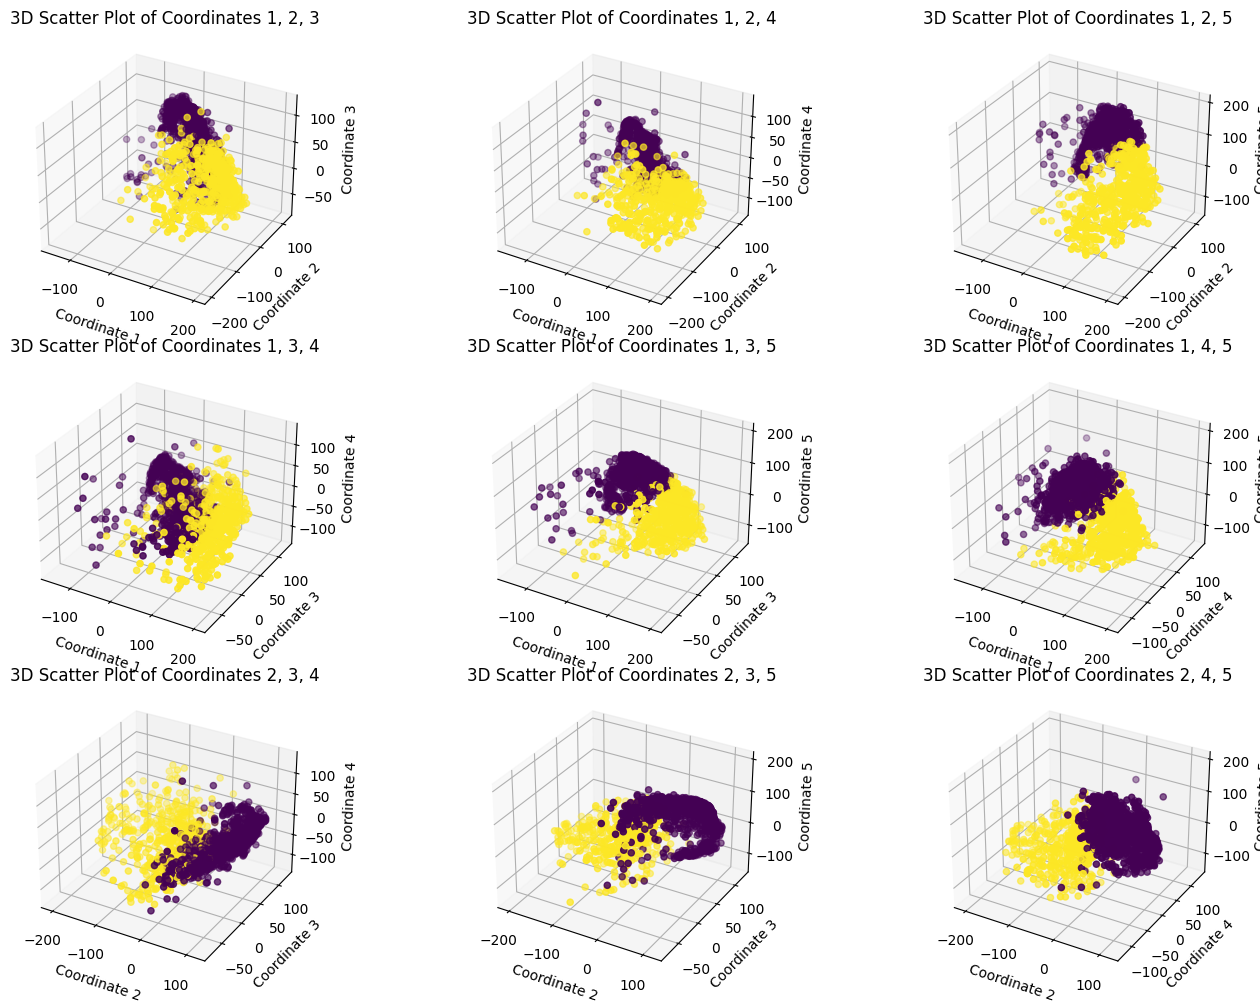

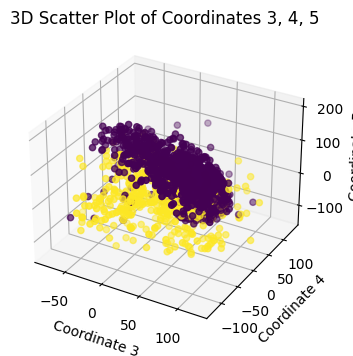

In [267]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans2.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

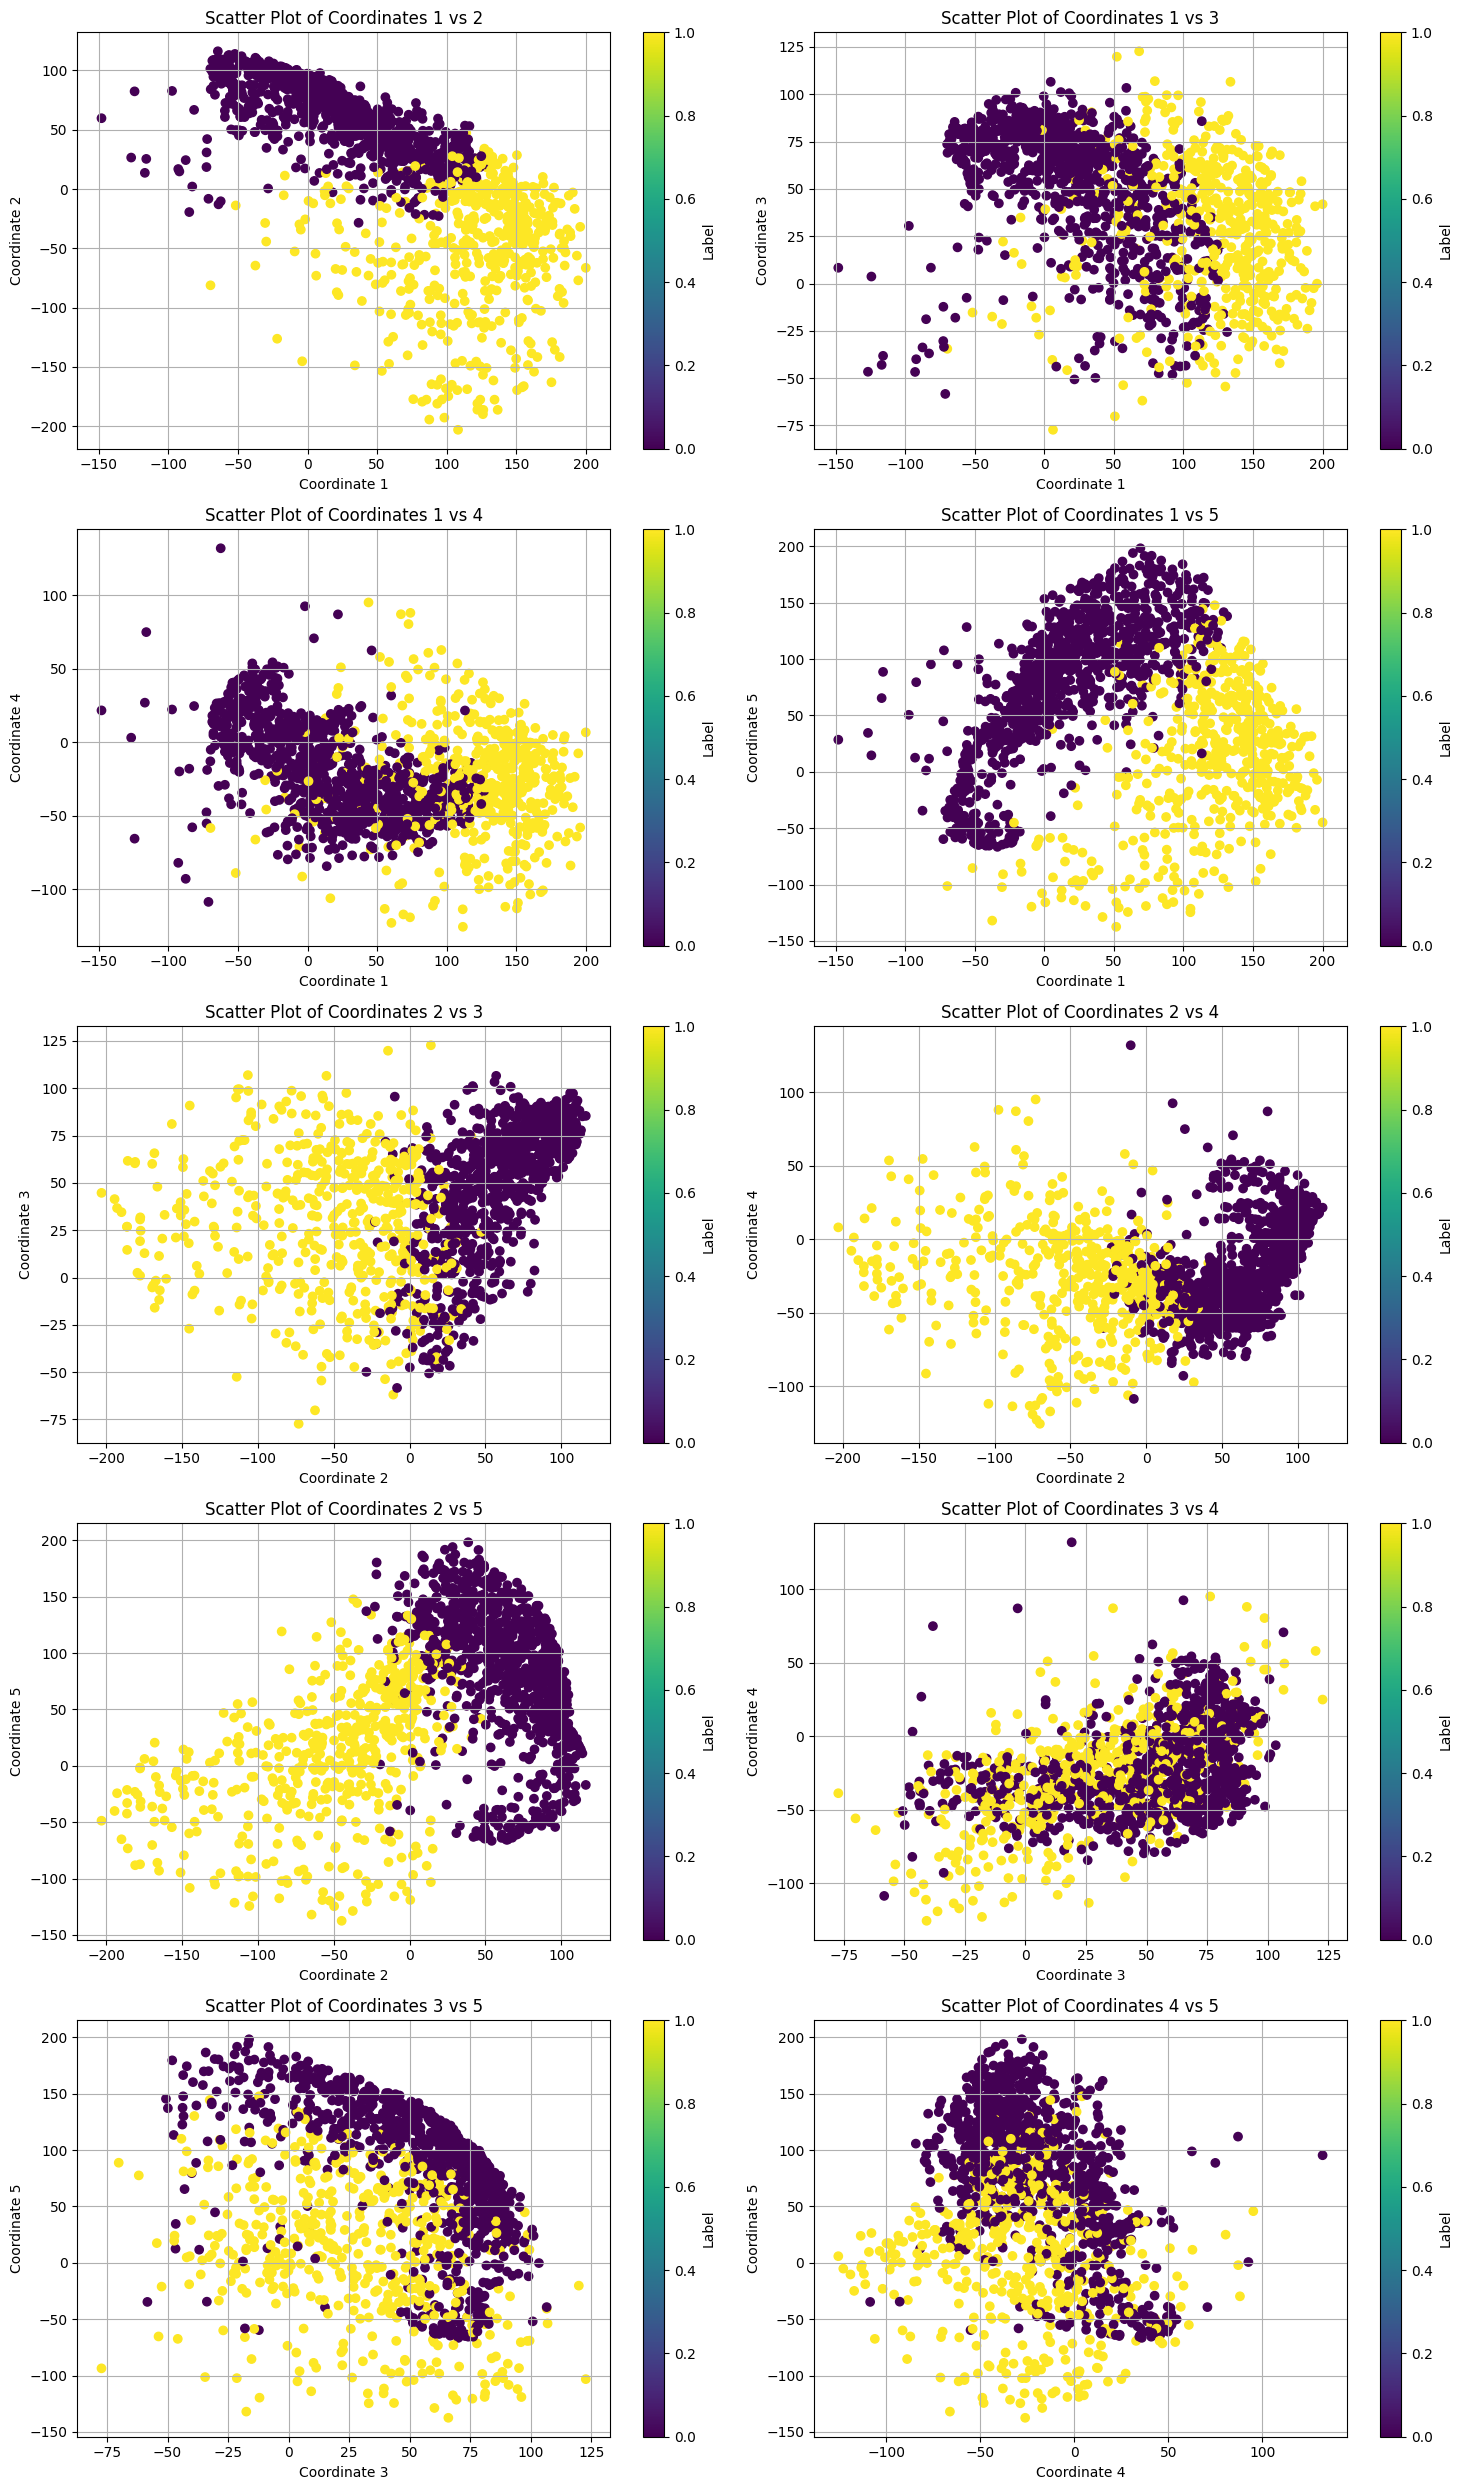

In [268]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=kmeans2.labels_, cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [269]:
data_loaded = np.load(os.path.join(swift.results_path, f'SWIFT_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz'))
names_64ms, features_64ms = data_loaded['names'], data_loaded['data']

In [270]:
names_64ms = names_64ms[mask]

Finding Durations: 100%|█████████████████████| 996/996 [00:21<00:00, 46.93GRB/s]


Text(0, 0.5, 'Number of GRBs')

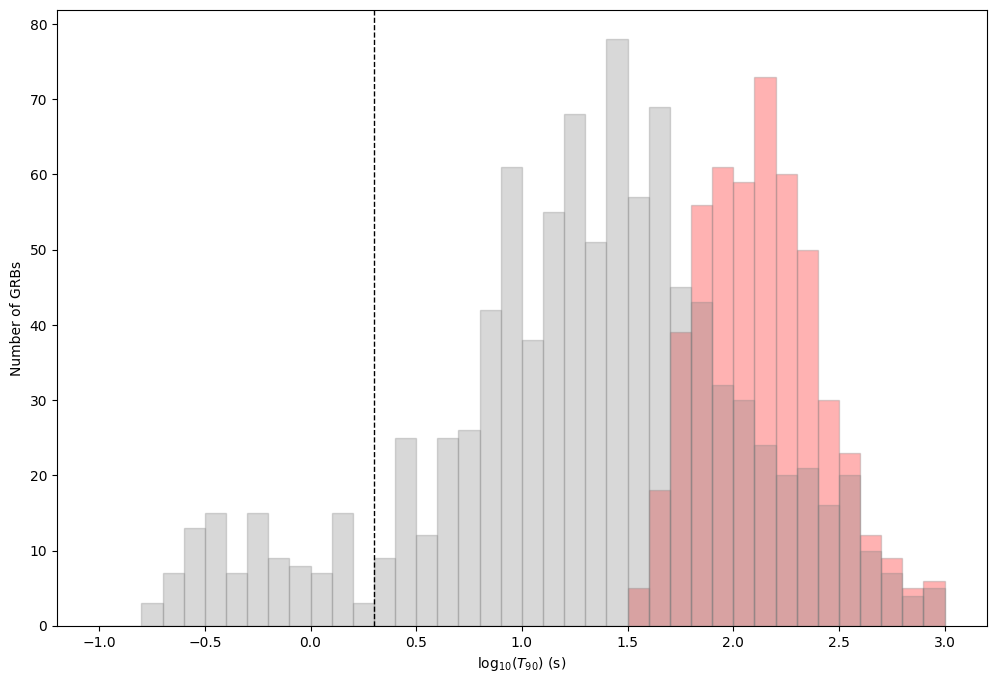

In [271]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match = kmeans2.labels_==1
match2 = kmeans2.labels_==0
names1 = names_64ms[match]
names2 = names_64ms[match2]
swift.duration_histogram(names=[names1, names2], alpha=0.3, color_groups=['r', 'gray'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [272]:
fname = f'autoencoded_nr_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.pt'
torch.save(preds2, fname)

In [273]:
durations[mask].shape

(1502,)

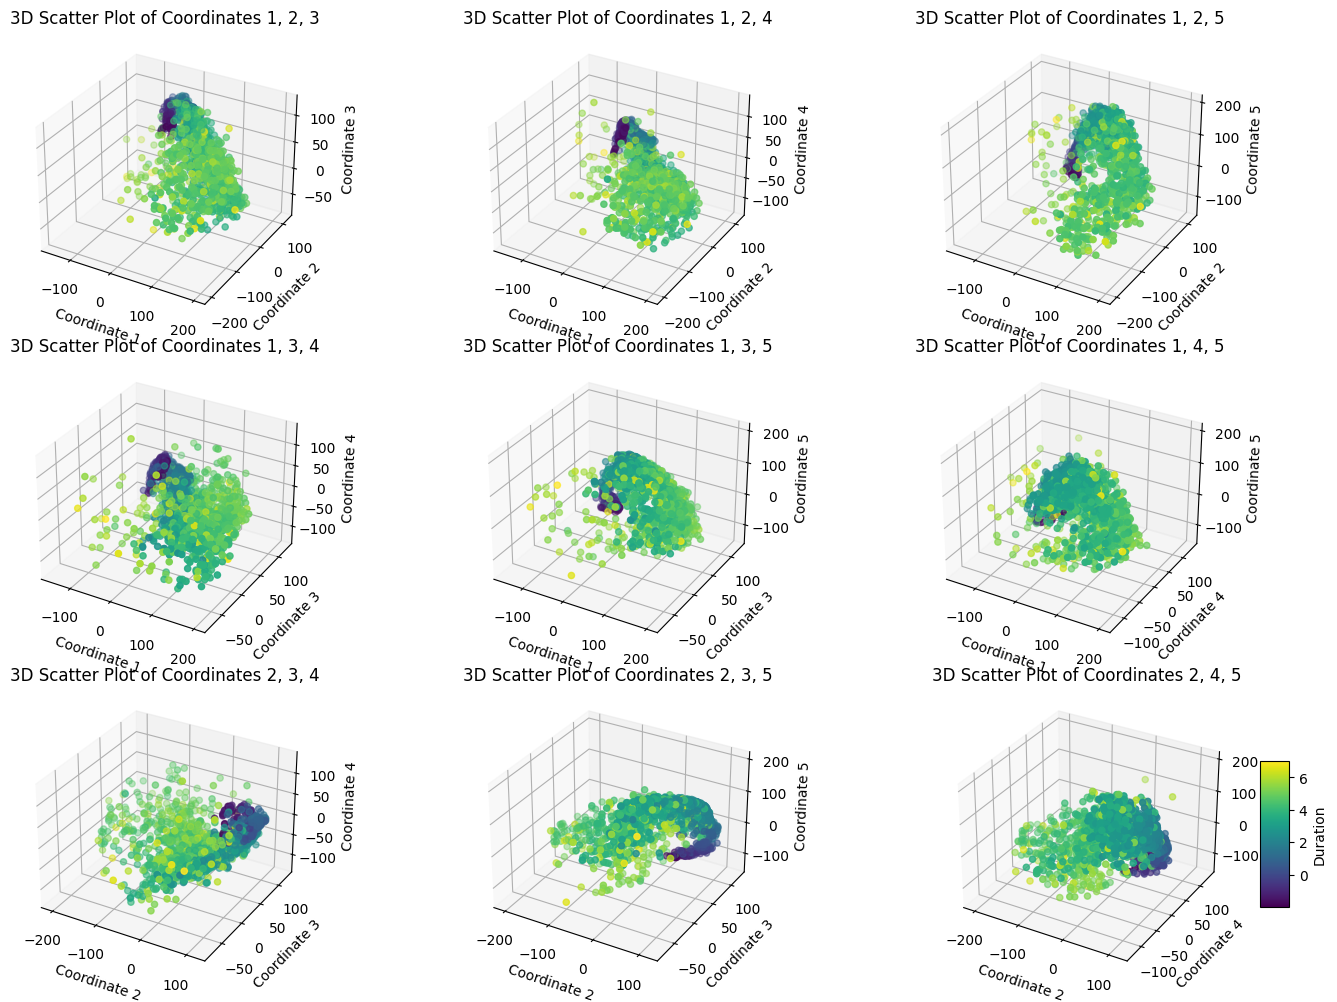

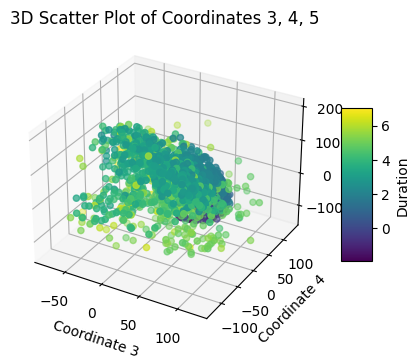

In [274]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(5), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


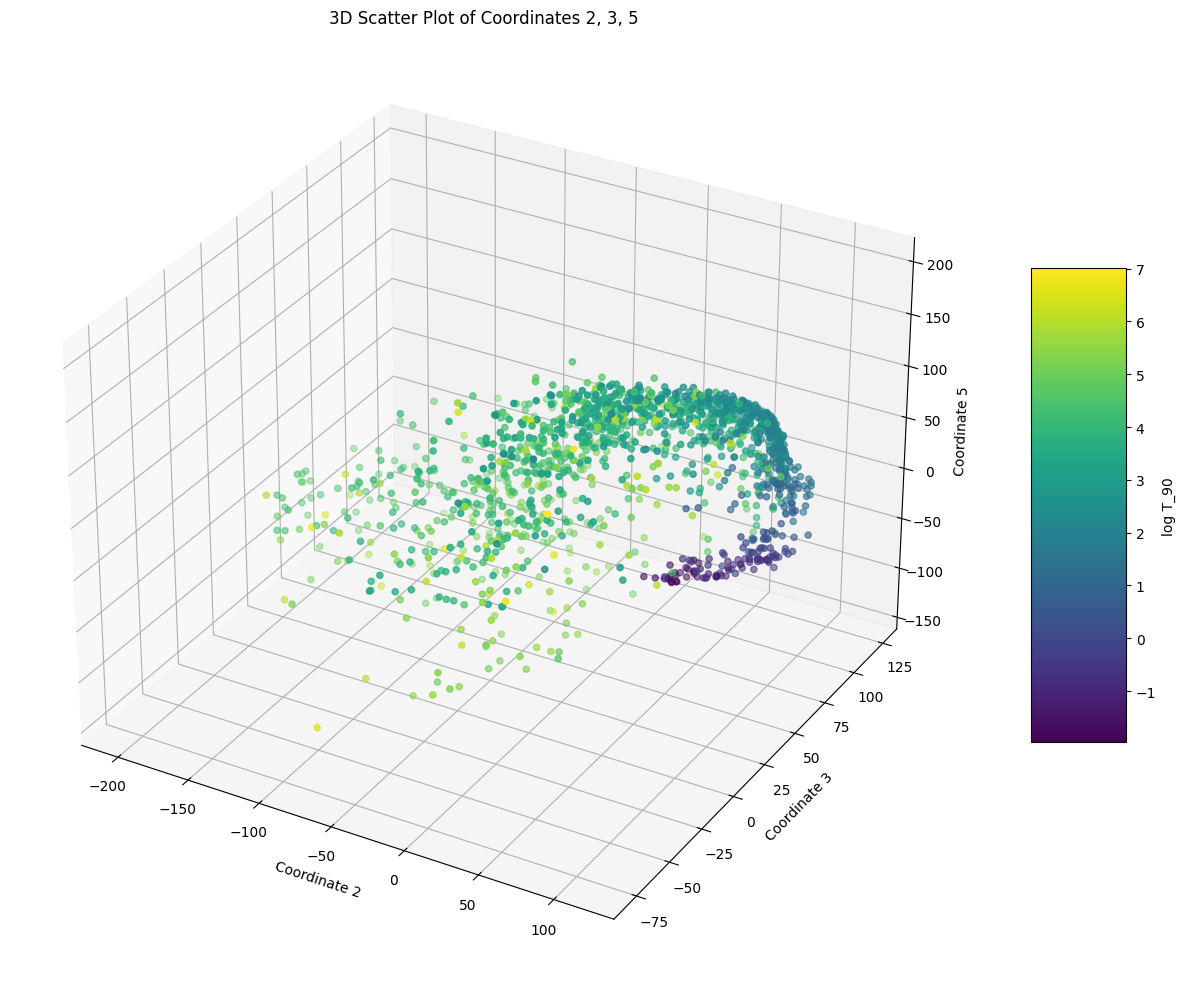

In [300]:


fig = plt.figure(figsize=(15, 10))
x, y, z = [1,2,4]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis')
ax.set_xlabel(f'Coordinate {x+1}')
ax.set_ylabel(f'Coordinate {y+1}')
ax.set_zlabel(f'Coordinate {z+1}')
ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='log T_90')  # Add a colorbar with label
plt.tight_layout()
plt.show()


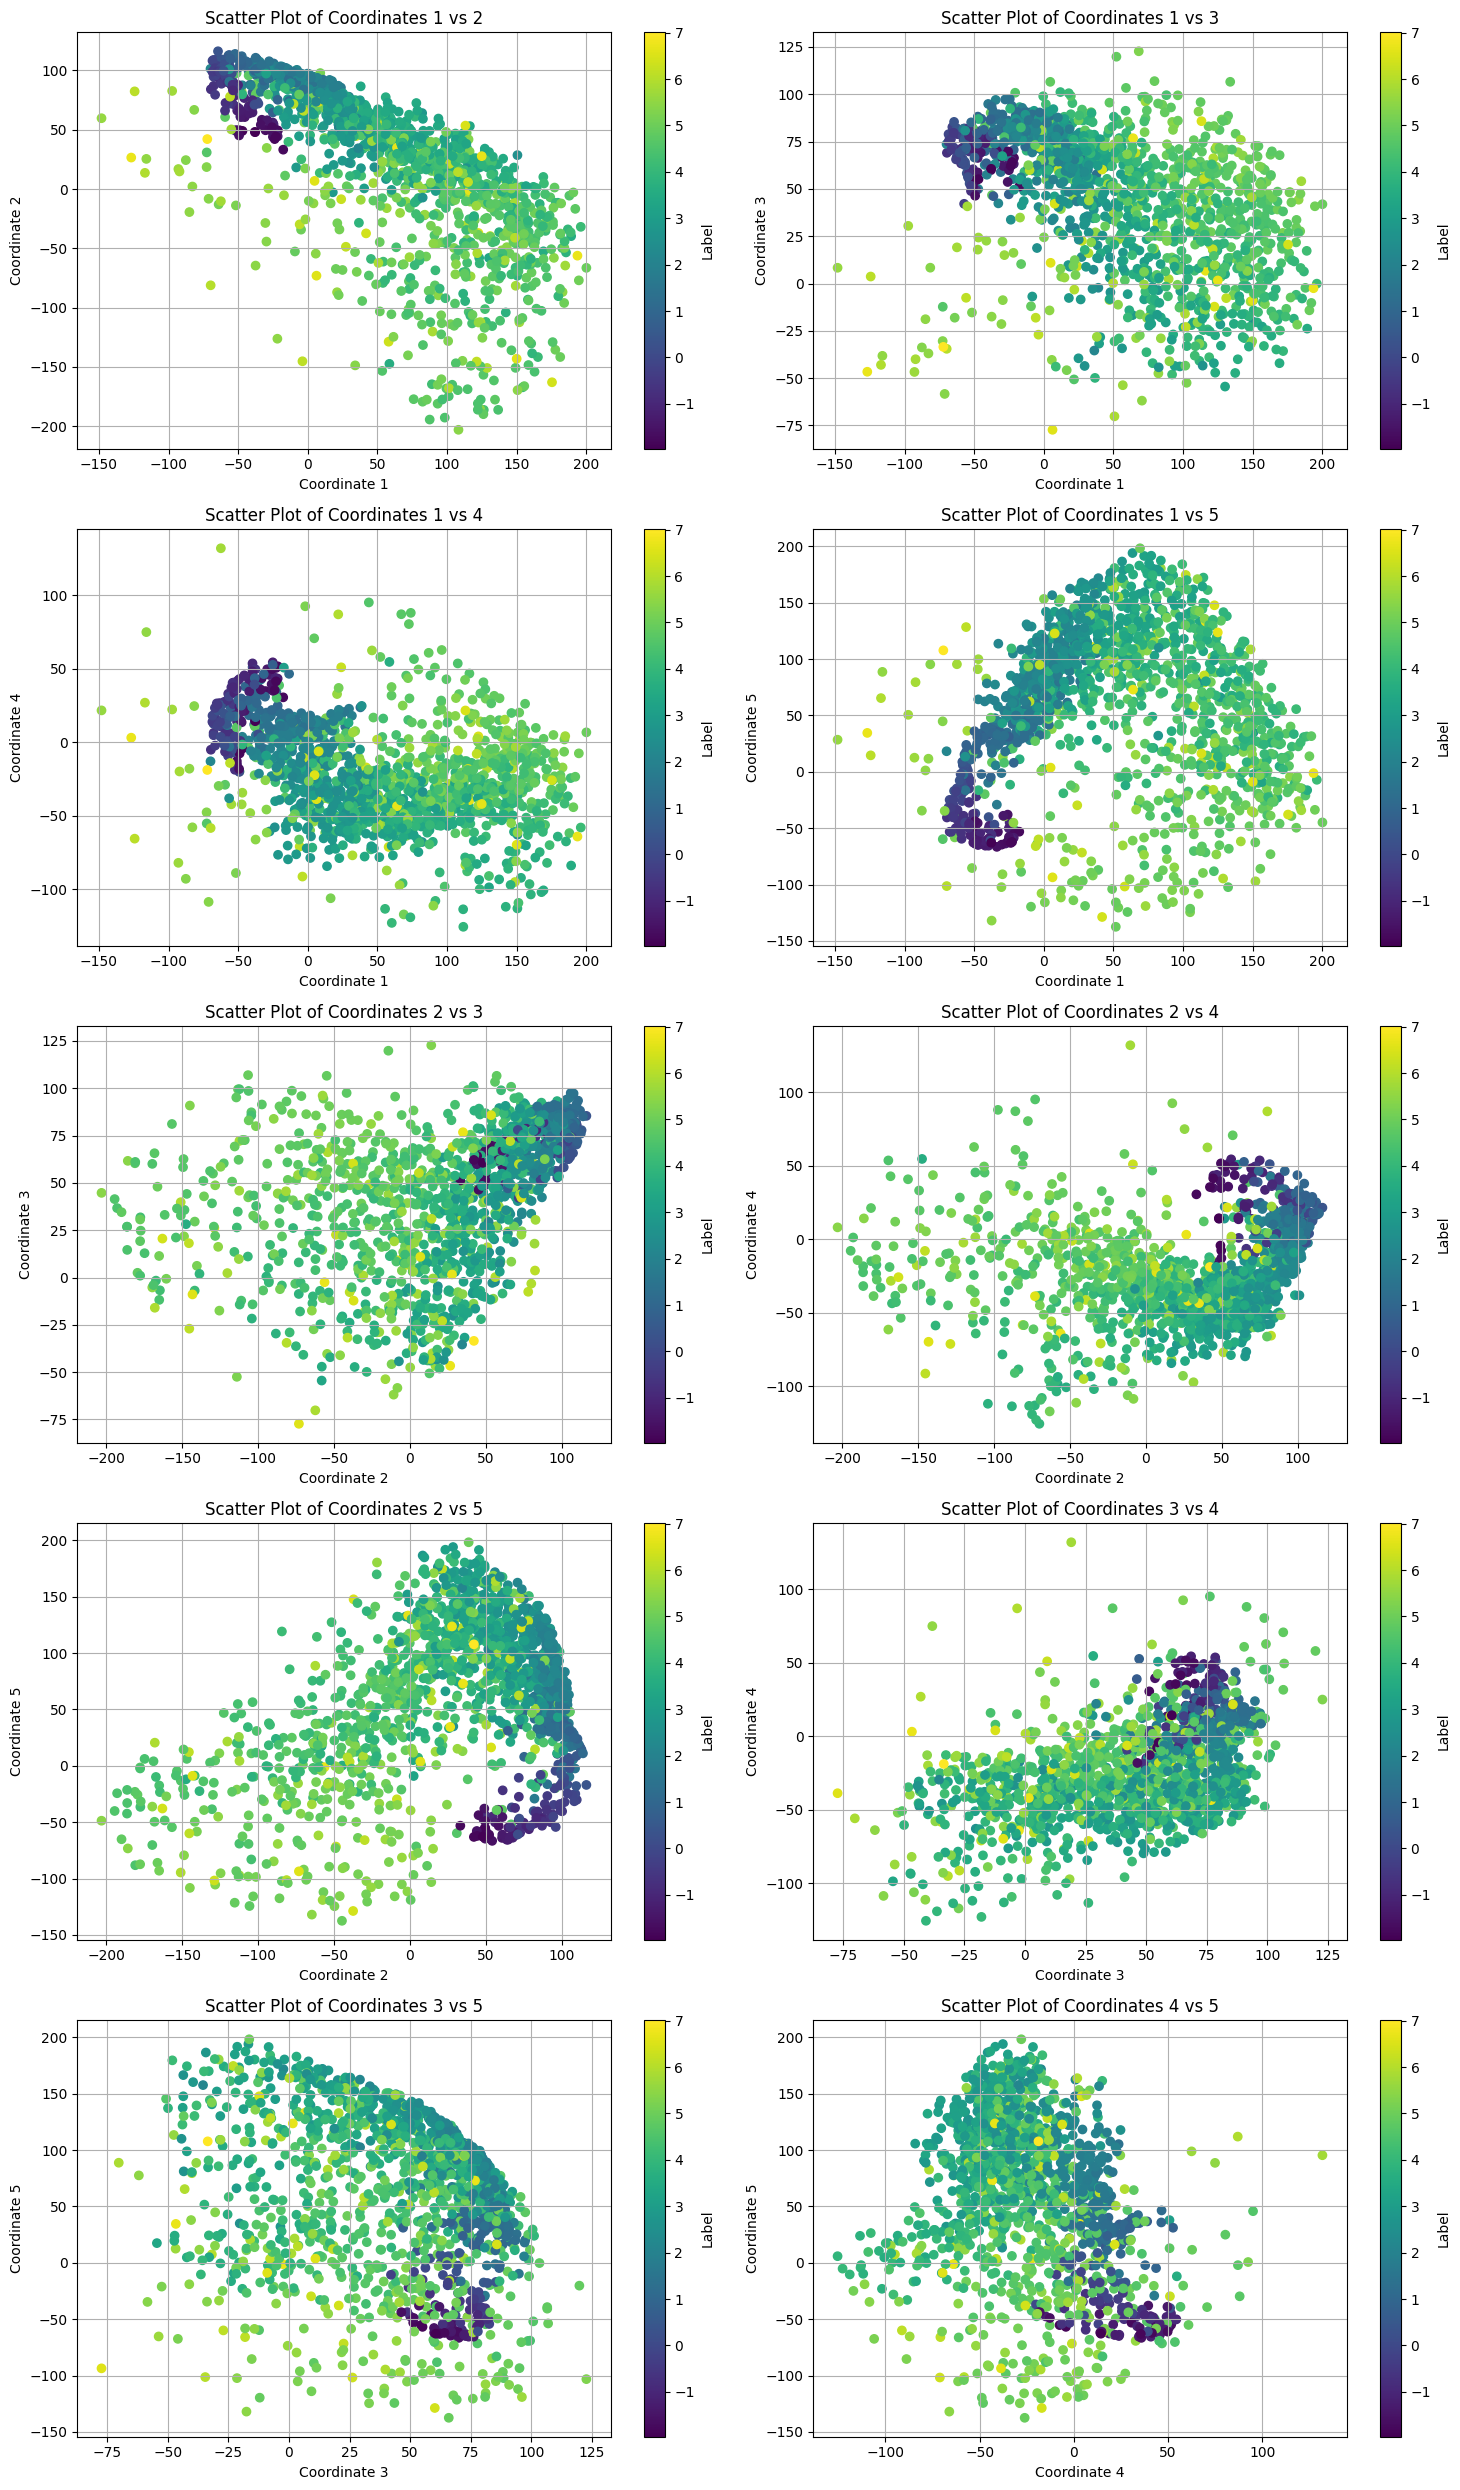

In [275]:
# Generate all combinations of the 5 coordinates taken 2 at a time
combos = list(itertools.combinations(range(5), 2))

# Create plots for all combinations
fig, axs = plt.subplots(5, 2, figsize=(15, 25))  # Adjust subplot grid as needed

for i, (idx1, idx2) in enumerate(combos):
    ax = axs[i//2, i%2]  # Determine the subplot for the current combo
    scatter = ax.scatter(preds2[:, idx1].numpy(), preds2[:, idx2].numpy(), c=np.log(durations[mask]), cmap='viridis')
    ax.set_title(f'Scatter Plot of Coordinates {idx1+1} vs {idx2+1}')
    ax.set_xlabel(f'Coordinate {idx1+1}')
    ax.set_ylabel(f'Coordinate {idx2+1}')
    ax.grid(True)

    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Label')

plt.tight_layout()
plt.show()

In [276]:
import numpy as np


# Exploring the array
print("Shape of the array:", durations[mask].shape)
print("Data type of the array:", durations[mask].dtype)
print("Number of dimensions:", durations[mask].ndim)
print("Total number of elements:", durations[mask].size)

# Describing the durations[mask]
print("Mean of the array:", np.mean(durations[mask]))
print("Standard deviation:", np.std(durations[mask]))
print("Minimum value:", np.min(durations[mask]))
print("Maximum value:", np.max(durations[mask]))
print("25th percentile:", np.percentile(durations[mask], 25))
print("Median:", np.median(durations[mask]))
print("75th percentile:", np.percentile(durations[mask], 75))
print("90th percentile:", np.percentile(durations[mask], 90))
print("95th percentile:", np.percentile(durations[mask], 95))
print("99th percentile:", np.percentile(durations[mask], 99))

Shape of the array: (1502,)
Data type of the array: float64
Number of dimensions: 1
Total number of elements: 1502
Mean of the array: 76.43213315579227
Standard deviation: 107.92946152195434
Minimum value: 0.14
Maximum value: 1104.7520000000002
25th percentile: 11.835
Median: 41.013999999999996
75th percentile: 98.201
90th percentile: 182.63600000000005
95th percentile: 270.83860000000004
99th percentile: 548.7248400000002


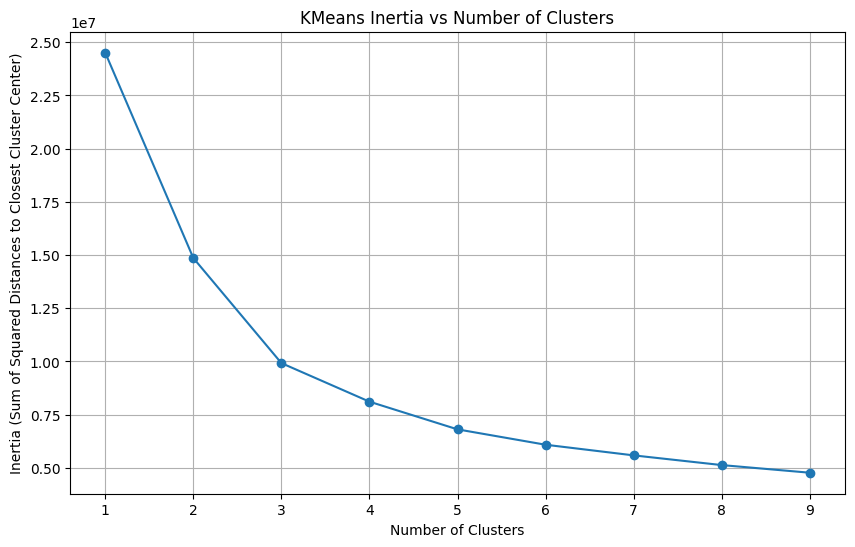

In [277]:
# Try different numbers of clusters
num_clusters = range(1, 10)  # You can adjust the range as needed
inertias = []

for k in num_clusters:
    kmeans = KMeans(n_clusters=k, random_state=205)
    kmeans.fit(encoded2)
    inertias.append(kmeans.inertia_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, inertias, marker='o')
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Sum of Squared Distances to Closest Cluster Center)')
plt.grid(True)
plt.show()

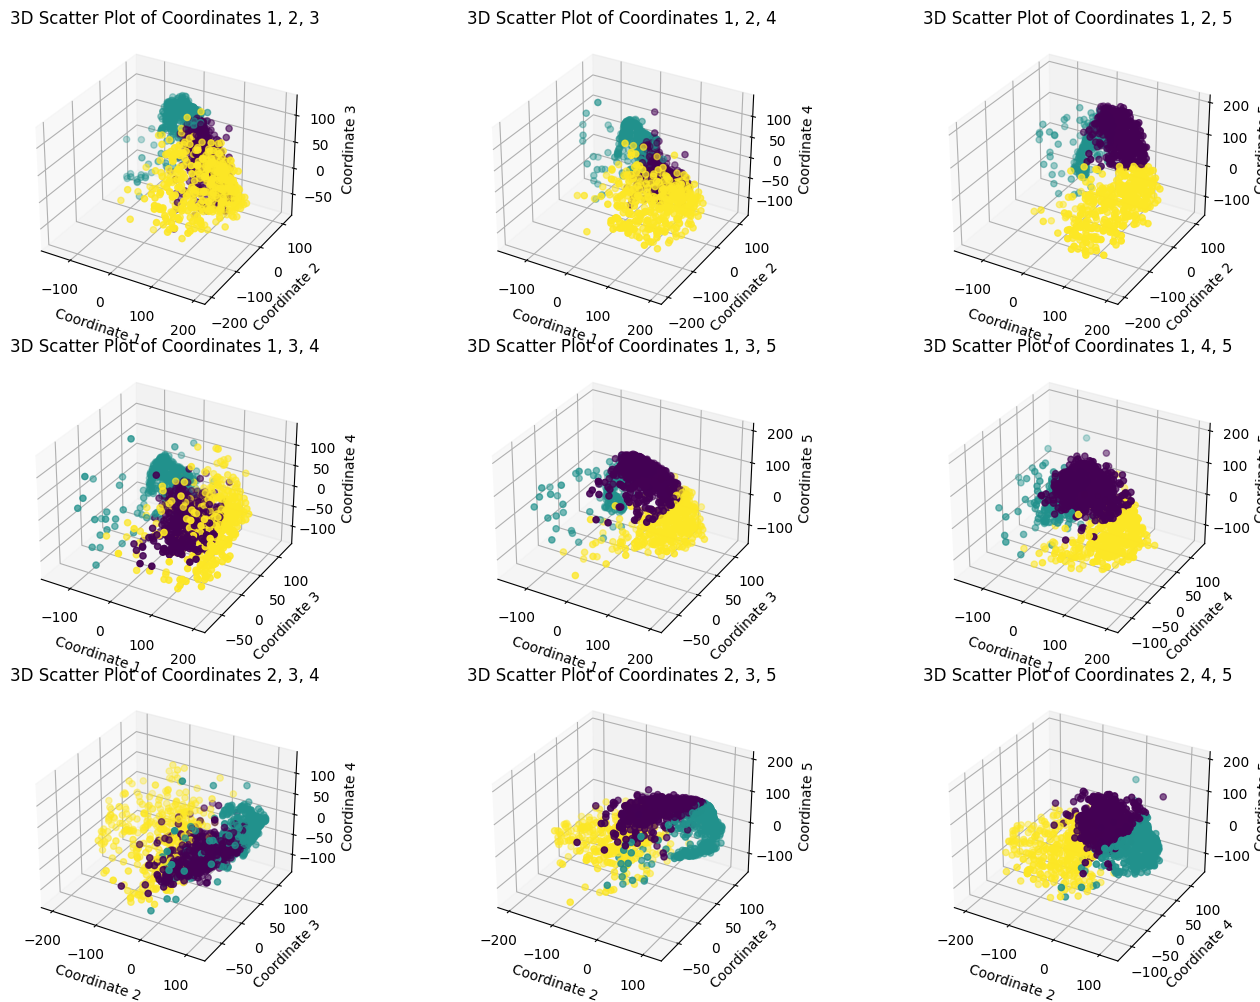

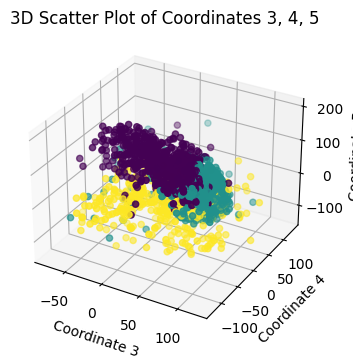

In [278]:
kmeans3 = KMeans(n_clusters=3, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

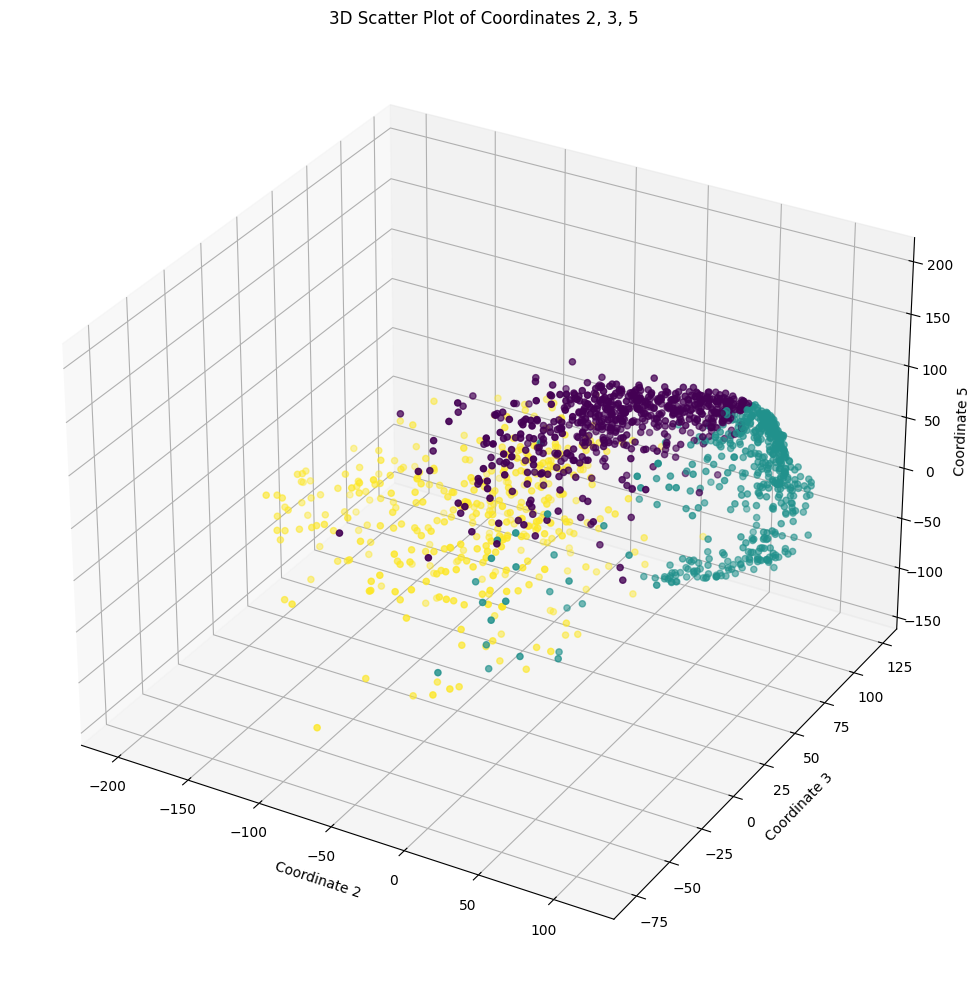

In [302]:
fig = plt.figure(figsize=(15, 10))
x, y, z = [1,2,4]
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans3.labels_, cmap='viridis')
ax.set_xlabel(f'Coordinate {x+1}')
ax.set_ylabel(f'Coordinate {y+1}')
ax.set_zlabel(f'Coordinate {z+1}')
ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

plt.tight_layout()
plt.show()

Finding Durations: 100%|█████████████████████| 395/395 [00:15<00:00, 25.44GRB/s]


Text(0, 0.5, 'Number of GRBs')

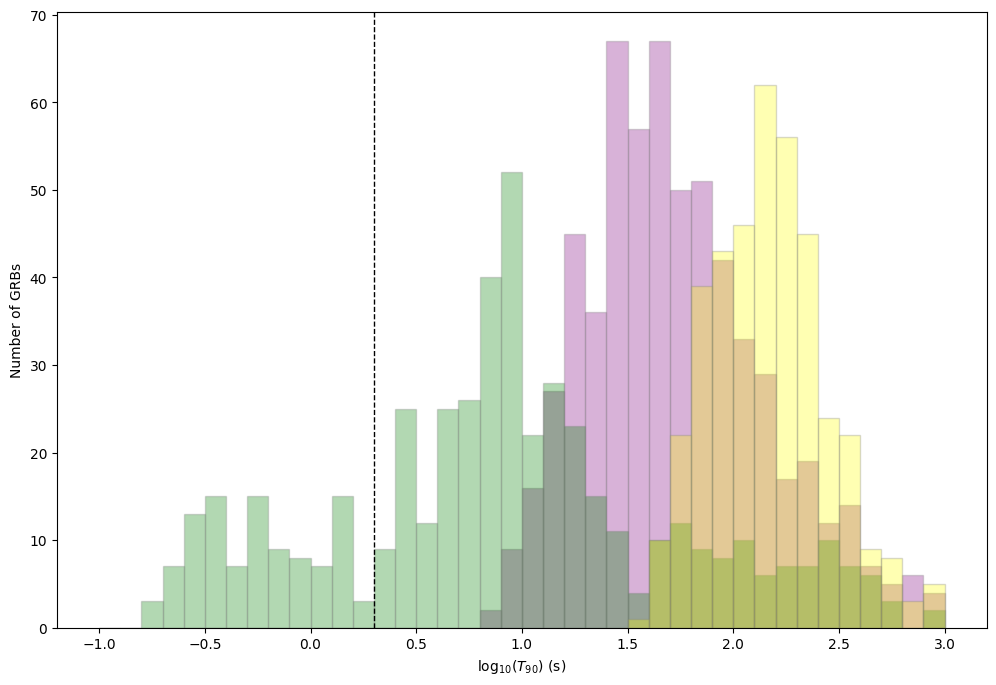

In [279]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans3.labels_==0
match2 = kmeans3.labels_==1
match3 = kmeans3.labels_==2
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
swift.duration_histogram(names=[names1, names2, names3], alpha=0.3, color_groups=['purple', 'green', 'yellow'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [303]:
compact_mergers = [
    "GRB130603B",
    "GRB060614",
    "GRB080503",
    "GRB050709",
    "GRB050724",
    "GRB061006",
    "GRB070714B",
    "GRB160821B",
    "GRB111005A",
    "GRB150101B",
    "GRB070809",
    "GRB211211A",
    "GRB211227A",
    "GRB191019A",
    "GRB230307A"
]

In [321]:
indices = np.where(np.isin(grb_names, compact_mergers))[0]
indices

array([  47,  140,  169,  226,  235,  291,  581,  732, 1016, 1259, 1417,
       1421])

In [320]:
indices = np.where(np.isin(names_64ms, compact_mergers))[0]
indices

array([  47,  140,  169,  226,  235,  291,  581,  732, 1016, 1259, 1417,
       1421])

In [306]:
len(compact_mergers)

15

In [307]:
indices.shape

(12,)

In [308]:
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    indices = np.where(names_64ms == merger)[0]
    results[merger] = indices[0] if indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {'Not found' if value == -1 else value}")

GRB130603B: 732
GRB060614: 140
GRB080503: 291
GRB050709: Not found
GRB050724: 47
GRB061006: 169
GRB070714B: 226
GRB160821B: 1016
GRB111005A: 581
GRB150101B: Not found
GRB070809: 235
GRB211211A: 1417
GRB211227A: 1421
GRB191019A: 1259
GRB230307A: Not found


In [309]:
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    indices = np.where(names_64ms == merger)[0]
    results[merger] = indices[0] if indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans2.labels_[value]}")

GRB130603B: 0
GRB060614: 1
GRB080503: 1
GRB050709: 0
GRB050724: 0
GRB061006: 0
GRB070714B: 0
GRB160821B: 0
GRB111005A: 0
GRB150101B: 0
GRB070809: 0
GRB211211A: 0
GRB211227A: 1
GRB191019A: 1
GRB230307A: 0


In [310]:
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    indices = np.where(names_64ms == merger)[0]
    results[merger] = indices[0] if indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans3.labels_[value]}")

GRB130603B: 1
GRB060614: 2
GRB080503: 2
GRB050709: 0
GRB050724: 1
GRB061006: 1
GRB070714B: 1
GRB160821B: 1
GRB111005A: 0
GRB150101B: 0
GRB070809: 1
GRB211211A: 0
GRB211227A: 0
GRB191019A: 0
GRB230307A: 0


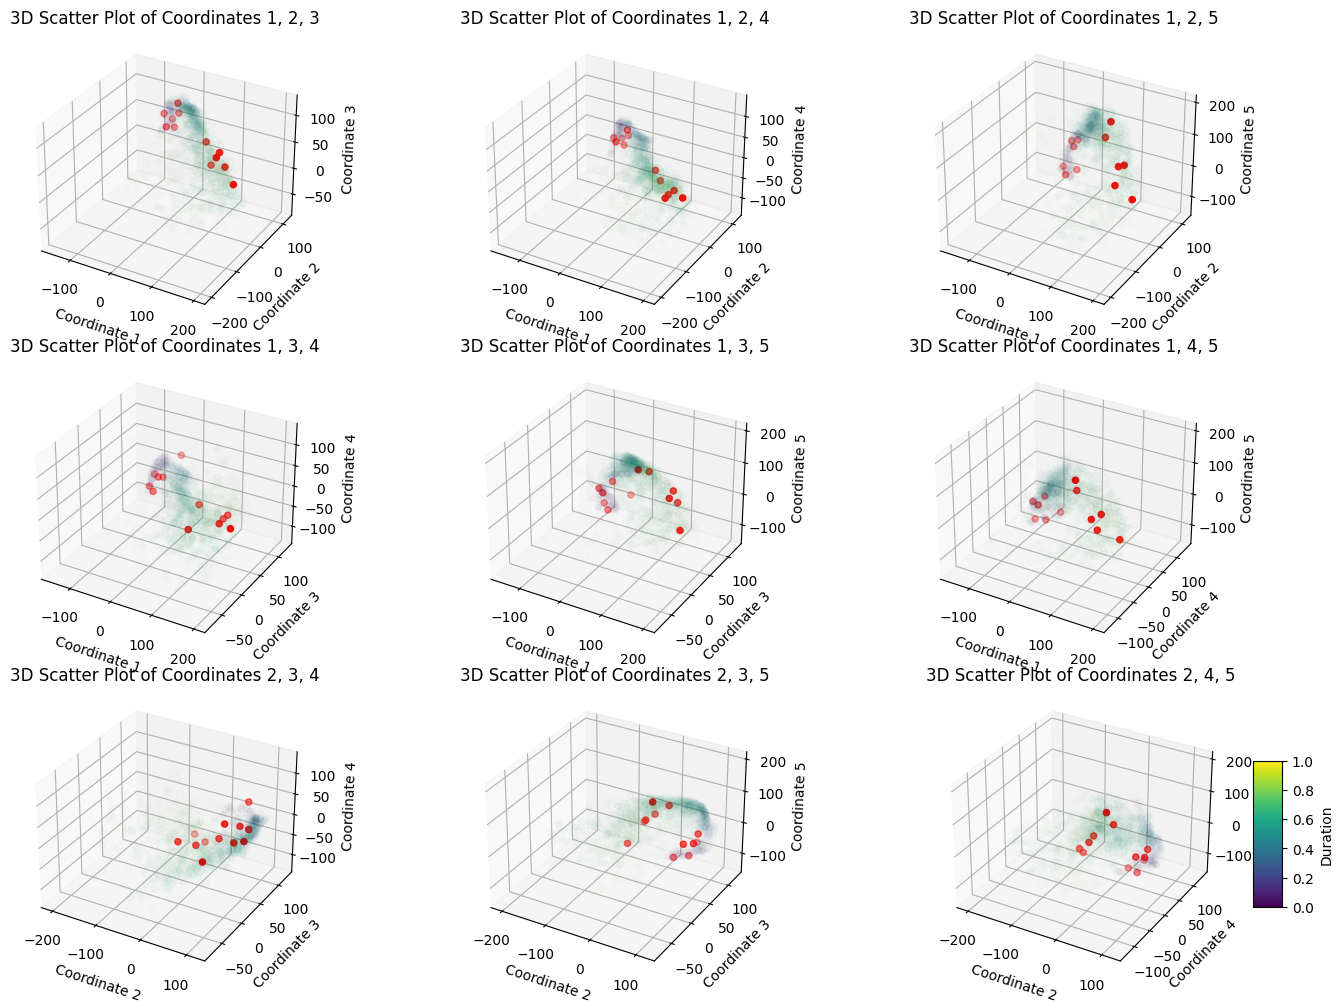

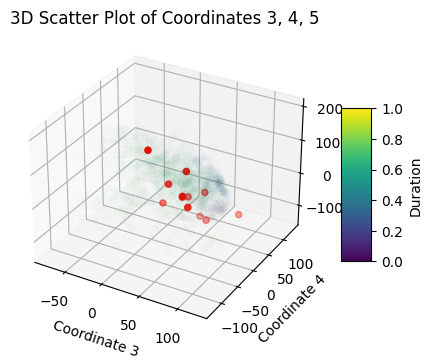

In [322]:
# Get all permutations of three columns out of five (0-based indices)
perms = list(combinations(range(LATENT_SIZE), 3))

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                # Use durations for coloring
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis',alpha=0.01)
                scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
        plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Duration')  # Add a colorbar with label
        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure


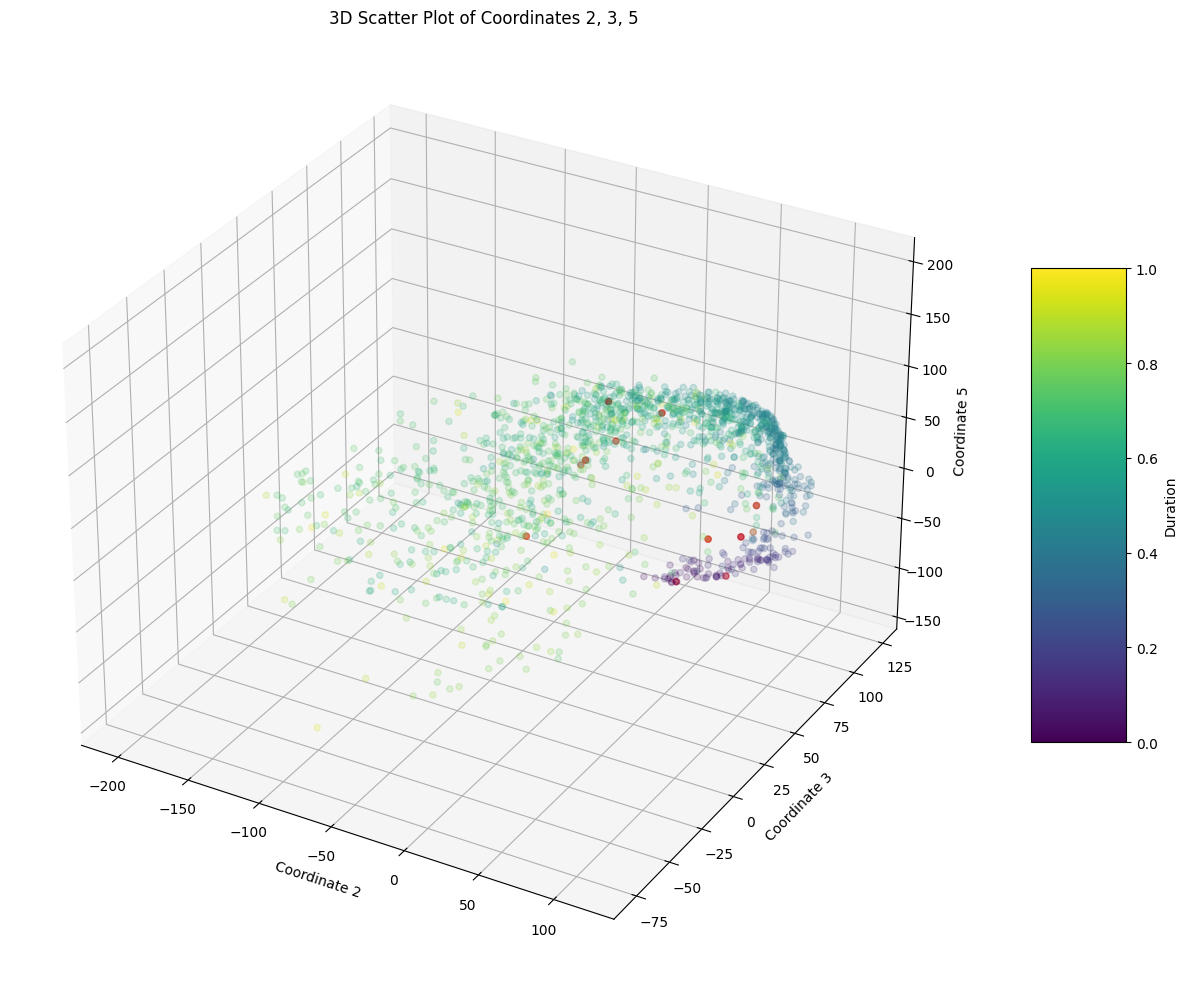

In [326]:
fig = plt.figure(figsize=(15, 10))
x, y, z = [1,2,4]
ax = fig.add_subplot(projection='3d')
# Use durations for coloring
scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=np.log(durations[mask]), cmap='viridis',alpha=0.2)
scatter = ax.scatter(preds2[indices, x], preds2[indices, y], preds2[indices, z], c='red')
ax.set_xlabel(f'Coordinate {x+1}')
ax.set_ylabel(f'Coordinate {y+1}')
ax.set_zlabel(f'Coordinate {z+1}')
ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')
plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Duration')  # Add a colorbar with label
plt.tight_layout()
plt.show()


In [312]:
print(preds2[indices, 0])
print(preds2[indices, 2])
print(preds2[indices, 3])

tensor([])
tensor([])
tensor([])


In [313]:
preds2.shape

torch.Size([1502, 5])

In [314]:
names_64ms.shape

(1502,)

In [315]:
indices

array([], dtype=int64)

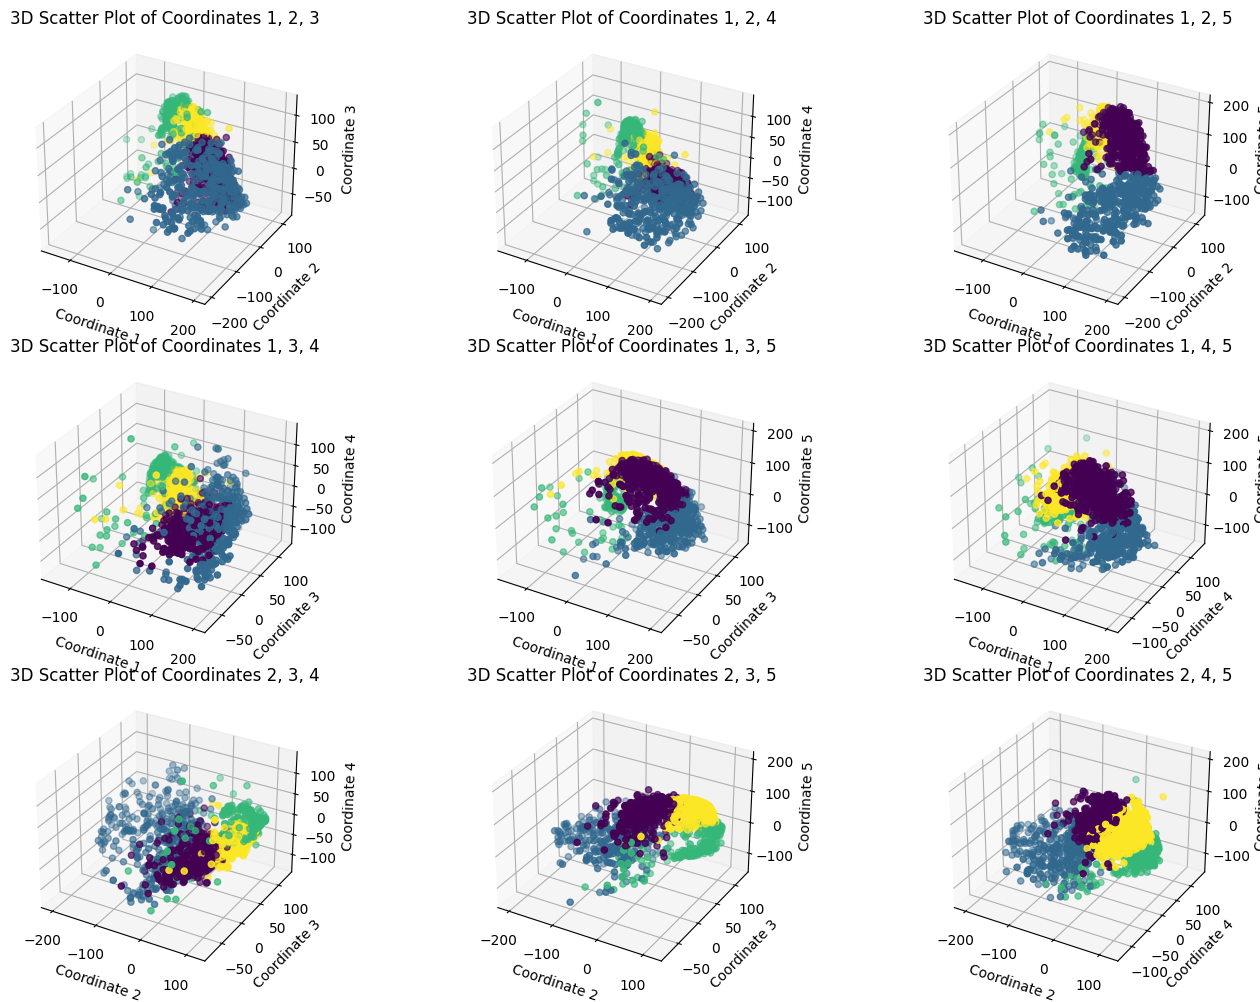

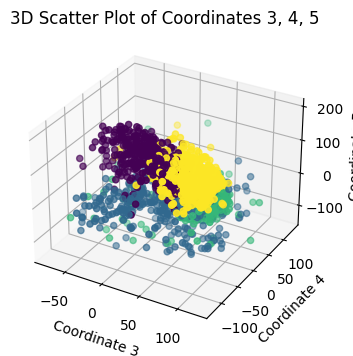

In [316]:
kmeans4 = KMeans(n_clusters=4, random_state=205).fit(encoded2)

# Function to create subplots for permutations
def create_subplots(permutations, rows, cols):
    fig_count = len(permutations) // (rows * cols) + (1 if len(permutations) % (rows * cols) > 0 else 0)
    for f in range(fig_count):
        fig = plt.figure(figsize=(15, 10))
        for i in range(1, rows * cols + 1):
            if rows * cols * f + i - 1 < len(permutations):
                x, y, z = permutations[rows * cols * f + i - 1]
                ax = fig.add_subplot(rows, cols, i, projection='3d')
                scatter = ax.scatter(preds2[:, x], preds2[:, y], preds2[:, z], c=kmeans4.labels_, cmap='viridis')
                ax.set_xlabel(f'Coordinate {x+1}')
                ax.set_ylabel(f'Coordinate {y+1}')
                ax.set_zlabel(f'Coordinate {z+1}')
                ax.set_title(f'3D Scatter Plot of Coordinates {x+1}, {y+1}, {z+1}')

        plt.tight_layout()
        plt.show()

# Adjust the number of rows and columns based on how many subplots you want per figure
create_subplots(perms, 3, 3)  # Example: 9 plots per figure

Finding Durations: 100%|█████████████████████| 466/466 [00:18<00:00, 25.18GRB/s]


Text(0, 0.5, 'Number of GRBs')

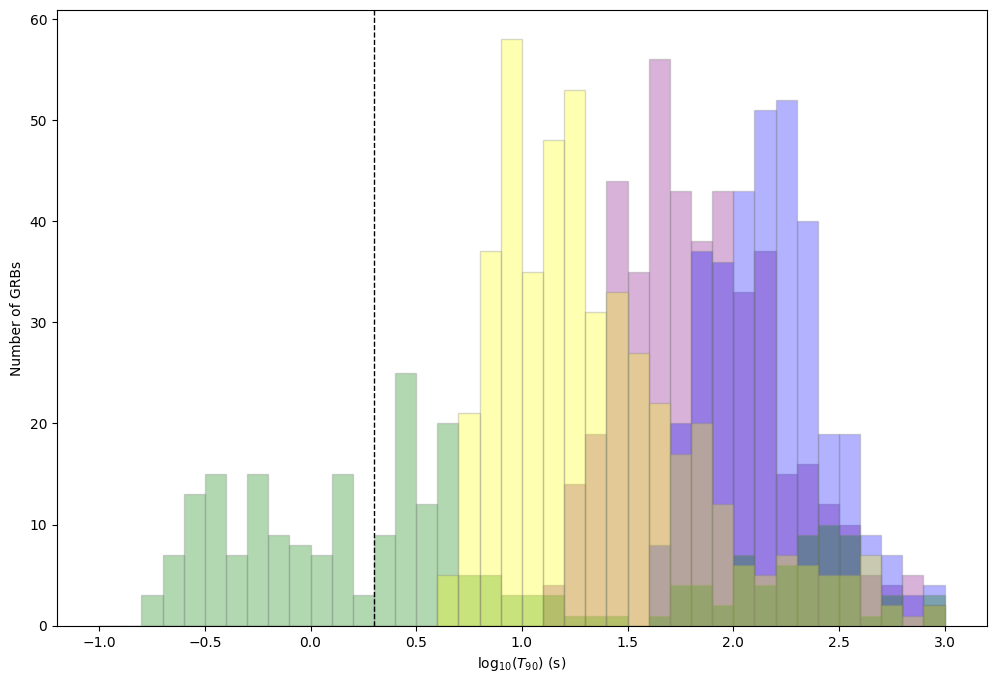

In [317]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
match1 = kmeans4.labels_==0
match2 = kmeans4.labels_==1
match3 = kmeans4.labels_==2
match4 = kmeans4.labels_==3
names1 = names_64ms[match1]
names2 = names_64ms[match2]
names3 = names_64ms[match3]
names4 = names_64ms[match4]
swift.duration_histogram(names=[names1, names2, names3,names4], alpha=0.3, color_groups=['purple', 'blue', 'green', 'yellow'], ax=ax)
ax.axvline(x=np.log10(2), c='k', ls='--', linewidth=1)
ax.set_xlabel(r'log$_{10}(T_{90})$ (s)')
ax.set_ylabel('Number of GRBs')

In [318]:
# Initialize a dictionary to store the results with the merger names as keys
results = {merger: None for merger in compact_mergers}  # Start with None or any placeholder for not found

# Find indices for each item in compact_mergers within names_64ms
for merger in compact_mergers:
    indices = np.where(names_64ms == merger)[0]
    results[merger] = indices[0] if indices.size > 0 else -1  # Store index if found, else store -1

# Printing the results
for key, value in results.items():
    print(f"{key}: {kmeans4.labels_[value]}")

GRB130603B: 2
GRB060614: 1
GRB080503: 1
GRB050709: 0
GRB050724: 2
GRB061006: 2
GRB070714B: 2
GRB160821B: 2
GRB111005A: 0
GRB150101B: 0
GRB070809: 2
GRB211211A: 0
GRB211227A: 0
GRB191019A: 0
GRB230307A: 0


In [319]:
fname = f'autoencoded_nr_64res_12345bands_DFT_True.pt'
preds2 = torch.load(fname)